# Data Processing

In [ ]:
import os
import json
import pandas as pd

os.makedirs("events", exist_ok=True)

In [ ]:
import os
import requests

# Ensure directories exist
os.makedirs("events", exist_ok=True)
os.makedirs("three_sixty", exist_ok=True)

# Define competition and season IDs for Euro 2024
competition_id = 55
season_id = 282

# Fetch match list for Euro 2024
matches_url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{competition_id}/{season_id}.json"
matches_response = requests.get(matches_url)
matches = matches_response.json()

match_ids = [match["match_id"] for match in matches]
print(f"Total Euro 2024 matches: {len(match_ids)}")

# Download event and 360 data for each match
for match_id in match_ids:
    event_url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json"
    event_response = requests.get(event_url)

    if event_response.status_code == 200:
        with open(f"events/{match_id}.json", "w") as f:
            f.write(event_response.text)
        print(f"Downloaded event: {match_id}")
    else:
        print(f"Failed to get event: {match_id}")

    freeze_url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/{match_id}.json"
    freeze_response = requests.get(freeze_url)

    if freeze_response.status_code == 200:
        with open(f"three_sixty/{match_id}.json", "w") as f:
            f.write(freeze_response.text)
        print(f"Downloaded 360: {match_id}")
    else:
        print(f"No 360 data for: {match_id}")


In [ ]:
import os
import json
import pandas as pd

event_folder = "events"
freeze_folder = "three_sixty"

# Get match IDs from the filenames in the events folder
match_ids = [f.replace(".json", "") for f in os.listdir(event_folder) if f.endswith(".json")]

all_shots = []

for match_id in match_ids:
    event_path = os.path.join(event_folder, f"{match_id}.json")
    freeze_path = os.path.join(freeze_folder, f"{match_id}.json")

    if not os.path.exists(freeze_path):
        continue

    with open(event_path, "r") as f:
        events = json.load(f)

    with open(freeze_path, "r") as f:
        freeze_frames = json.load(f)

    # Build lookup for event_uuid to freeze_frame
    freeze_lookup = {f["event_uuid"]: f.get("freeze_frame", []) for f in freeze_frames if "event_uuid" in f}

    for event in events:
        if event["type"]["name"] == "Shot":
            shot_id = event["id"]
            freeze_data = freeze_lookup.get(shot_id, [])

            # Collect opponent locations only
            opponent_locations = [
                p["location"]
                for p in freeze_data
                if p.get("teammate") == False and "location" in p
            ]

            event["opponent_locations"] = opponent_locations
            all_shots.append(event)

# Normalize nested JSON structure and export
df = pd.json_normalize(all_shots)
df.to_csv("euro_2024_shots.csv", index=False)

df.head()

,id,index,period,timestamp,minute,second,possession,location,duration,under_pressure,...,shot.saved_to_post,shot.first_time,shot.deflected,shot.open_goal,out,shot.one_on_one,shot.follows_dribble,shot.saved_off_target,shot.redirect,off_camera
0,2d04779f-9437-4d12-8547-8716301a2f75,582,1,00:12:11.573,12,11,17,"[113.4, 39.5]",0.421466,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b4037d07-f01d-41d7-a4da-a7659965dee4,898,1,00:18:04.480,18,4,25,"[95.8, 51.0]",1.461026,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2bb39cba-c542-4a26-9fd7-3b6f3f0a5089,976,1,00:19:40.945,19,40,30,"[103.0, 47.3]",0.686138,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4c867e00-d70d-4c4c-af92-fe33fc68de1c,1060,1,00:22:39.487,22,39,33,"[98.9, 46.6]",0.078494,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8236023f-622e-48d2-a13c-d6633da9b964,1298,1,00:29:49.941,29,49,43,"[92.2, 46.3]",0.378451,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(df.columns.tolist())

['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'location', 'duration', 'under_pressure', 'related_events', 'opponent_locations', 'type.id', 'type.name', 'possession_team.id', 'possession_team.name', 'play_pattern.id', 'play_pattern.name', 'team.id', 'team.name', 'player.id', 'player.name', 'position.id', 'position.name', 'shot.statsbomb_xg', 'shot.end_location', 'shot.outcome.id', 'shot.outcome.name', 'shot.technique.id', 'shot.technique.name', 'shot.aerial_won', 'shot.body_part.id', 'shot.body_part.name', 'shot.type.id', 'shot.type.name', 'shot.freeze_frame', 'shot.key_pass_id', 'shot.saved_to_post', 'shot.first_time', 'shot.deflected', 'shot.open_goal', 'out', 'shot.one_on_one', 'shot.follows_dribble', 'shot.saved_off_target', 'shot.redirect', 'off_camera']


## Feature Engineering

The features I will be using are:
- distance from goal
- angle to goal
- shot body part
- shot type
- number of defenders in path/zone to goal
- closest defender's distance to shooter


In [ ]:
import numpy as np
import pandas as pd
import json

# Load the shot data with opponent positions
df = pd.read_csv("euro_2024_shots.csv")

# Helper functions for feature engineering
def distance_to_goal(x, y):
    return np.sqrt((120 - x)**2 + (40 - y)**2)

def angle_to_goal(x, y):
    a1 = np.arctan2(36 - y, 120 - x)
    a2 = np.arctan2(44 - y, 120 - x)
    return abs(a2 - a1)

def defenders_in_shot_cone(x, y, defenders):
    a1 = np.arctan2(36 - y, 120 - x)
    a2 = np.arctan2(44 - y, 120 - x)
    a_min, a_max = min(a1, a2), max(a1, a2)

    count = 0
    for def_x, def_y in defenders:
        angle = np.arctan2(def_y - y, def_x - x)
        if a_min <= angle <= a_max:
            count += 1
    return count

def closest_defender_distance(x, y, defenders):
    if not defenders:
        return np.nan
    return min(np.linalg.norm([def_x - x, def_y - y]) for def_x, def_y in defenders)

# Prepare engineered features
engineered_features = []

for _, row in df.iterrows():
    try:
        x, y = row["location"][1:-1].split(", ")
        x, y = float(x), float(y)
    except:
        x, y = np.nan, np.nan

    try:
        defenders = json.loads(row["opponent_locations"].replace("'", '"'))
    except:
        defenders = []

    engineered_features.append({
        "distance_to_goal": distance_to_goal(x, y) if not np.isnan(x) else np.nan,
        "angle_to_goal": angle_to_goal(x, y) if not np.isnan(x) else np.nan,
        "shot_body_part": row.get("shot.body_part.name", None),
        "shot_type": row.get("shot.technique.name", None),
        "num_defenders_in_path": defenders_in_shot_cone(x, y, defenders) if not np.isnan(x) else np.nan,
        "closest_defender_distance": closest_defender_distance(x, y, defenders) if not np.isnan(x) else np.nan,
    })

df_features = pd.DataFrame(engineered_features)

df_encoded = pd.get_dummies(df_features, columns=["shot_body_part", "shot_type"], dummy_na=True)

df_encoded.head()


,distance_to_goal,angle_to_goal,num_defenders_in_path,closest_defender_distance,shot_body_part_Head,shot_body_part_Left Foot,shot_body_part_Other,shot_body_part_Right Foot,shot_body_part_nan,shot_type_Backheel,shot_type_Diving Header,shot_type_Half Volley,shot_type_Lob,shot_type_Normal,shot_type_Overhead Kick,shot_type_Volley,shot_type_nan
0,6.618912,1.086014,1,0.699107,True,False,False,False,False,False,False,False,False,True,False,False,False
1,26.582701,0.273305,2,5.236587,False,False,False,True,False,False,False,True,False,False,False,False,False
2,18.501081,0.394911,2,1.378755,False,False,False,True,False,False,False,False,False,True,False,False,False
3,22.108143,0.342937,2,1.698528,False,True,False,False,False,False,False,False,False,True,False,False,False
4,28.504912,0.272277,3,11.367409,False,False,False,True,False,False,False,False,False,True,False,False,False


# Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

# Define features and labels
X = df_encoded
y = df['shot.outcome.name'].apply(lambda x: 1 if x == 'Goal' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]
df['xG'] = model.predict_proba(X)[:, 1]

# Evaluate
auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

print(f"AUC: {auc:.3f}")
print(f"Log Loss: {logloss:.4f}")

AUC: 0.774
Log Loss: 0.2537


In [ ]:
df[['xG', 'shot.statsbomb_xg']].dropna().head()

,xG,shot.statsbomb_xg
0,0.283386,0.289107
1,0.020081,0.025817
2,0.043631,0.095544
3,0.032950,0.037229
4,0.028213,0.053543


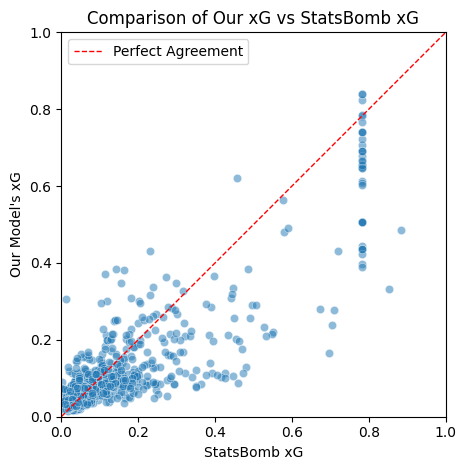

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=df, x='shot.statsbomb_xg', y='xG', alpha=0.5)
plt.xlabel("StatsBomb xG")
plt.ylabel("Our Model's xG")
plt.title("Comparison of Our xG vs StatsBomb xG")

plt.axis("square")
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Perfect Agreement')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(df['shot.statsbomb_xg'], df['xG'])
print(f"Mean Squared Error between xG models: {mse:.4f}")

Mean Squared Error between xG models: 0.0060


## Pretty Decent MSE and agreement to the StatsBomb xG

# Save the Model

In [ ]:
import joblib

joblib.dump(model, 'xg_modelv2.pkl')

['xg_modelv2.pkl']

In [ ]:
from google.colab import files
files.download('xg_modelv2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>